In [ ]:
%load_ext lab_black

from autolens.data import ccd
from autolens.data.array import mask as msk
from autolens.lens import lens_data as ld
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.model.galaxy import galaxy as g
from autolens.lens import ray_tracing
from autolens.data.plotters import ccd_plotters
from autolens.lens import lens_fit
from autolens.lens.plotters import ray_tracing_plotters
from autolens.lens.plotters import lens_fit_plotters

Next, we'll look at how we fit imaging of a strong lens in PyAutoLens, using the mass-profiles, light-profiles, galaxies and ray-tracing modules introduced previously. First, we'll need some data. We'll usse an example image that comes prepacked with PyAutoLens and can be loaded from a fits file (you'll need to change your path to the workspace path on your computer).

You need to change the path below to that of your workspace.

In [ ]:
workspace_path = "/path/to/user/autolens_workspace/"

The data path specifies where the data is located and loaded from. 

Its worth noting we're using a strong lens where the light profile of the lens galaxy is omitted.

In [ ]:
data_path = workspace_path + "data/example/lens_mass_and_x1_source/"

ccd_data = ccd.load_ccd_data_from_fits(
    image_path=data_path + "image.fits",
    noise_map_path=data_path + "noise_map.fits",
    psf_path=data_path + "psf.fits",
    pixel_scale=0.1,
)

FileNotFoundError: [Errno 2] No such file or directory: '/path/to/user/autolens_workspace/data/example/lens_mass_and_x1_source/image.fits'

There are four components of the data we need for lens modeling:

1) The image of the strong lens.

2) A noise-map, which weights how much each image pixels contributes to the fit (e.g. the likelihood function).

3) The PSF, which defines how the image is blurred during data accquization. The PSF is used by PyAutoLens to model this blurring during the fitting process.

4) The pixel-scale of the image, which defines the arcsecond to pixel conversion.

In [ ]:
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data)

NameError: name 'ccd_data' is not defined

To fit an image, we first specify a mask. A mask describes the sections of the image that we fit. Typically, we want to mask out regions of the image where the lens and source galaxies are not visible, for example at the edges where the signal is entirely background sky and noise. For our image a 3" circular mask will do the job. We can then plot this mask over our image, using it to 'extract' and 'zoom' the region of interest.

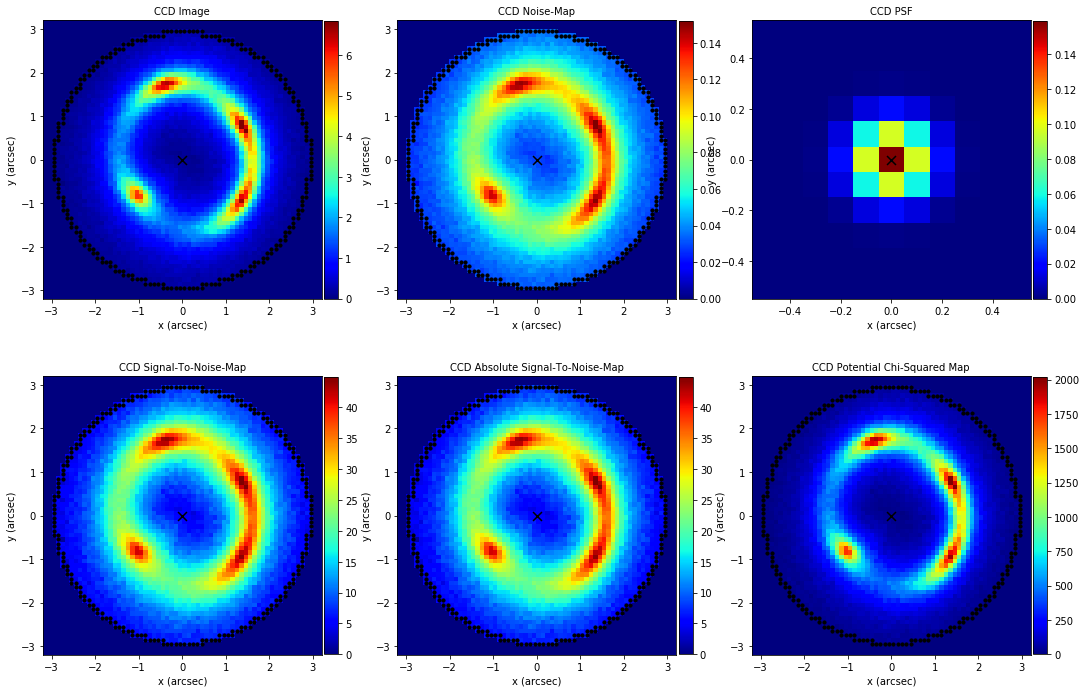

In [11]:
mask = msk.Mask.circular(
    shape=ccd_data.shape, pixel_scale=ccd_data.pixel_scale, radius_arcsec=3.0)

ccd_plotters.plot_ccd_subplot(
    ccd_data=ccd_data, mask=mask, extract_array_from_mask=True, zoom_around_mask=True)

Now we've loaded the ccd data and created a mask, we use them to create a 'lens data' object, which we'll perform using the lens_data module (imported as 'ld').

A lens data object is a 'package' of all parts of a data-set we need in order to fit it with a lens model:

1) The ccd-data, e.g. the image, PSF and noise-map.
2) The mask, so that only the regions of the image with a signal are fitted.
3) A grid-stack aligned to the ccd-imaging data's pixels: so our ray-tracing using the same (masked) grid as the image.

In [ ]:
lens_data = ld.LensData(ccd_data=ccd_data, mask=mask)

NameError: name 'ccd_data' is not defined

To fit an image, we need to create an image-plane image using a tracer. We'll use the same galaxies that I used to simulate the ccd data, so our fit should be 'perfect'.

Its worth noting that below, we use the lens_data's grid-stack to setup the tracer. This ensures that our image-plane image will be the same resolution and alignment as our image-data, as well as being masked appropriately.

In [ ]:
lens_galaxy = g.Galaxy(
    redshift=0.5,
    mass=mp.EllipticalIsothermal(
        centre=(0.0, 0.0), einstein_radius=1.6, axis_ratio=0.7, phi=45.0
    ),
    shear=mp.ExternalShear(magnitude=0.05, phi=90.0),
)

source_galaxy = g.Galaxy(
    redshift=1.0,
    light=lp.EllipticalSersic(
        centre=(0.1, 0.1),
        axis_ratio=0.8,
        phi=60.0,
        intensity=0.3,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)

tracer = ray_tracing.Tracer.from_galaxies_and_image_plane_grid_stack(
    galaxies=[lens_galaxy],
    galaxies=[source_galaxy],
    image_plane_grid_stack=lens_data.grid_stack,
)

ray_tracing_plotters.plot_image_plane_image(tracer=tracer)

NameError: name 'lens_data' is not defined

To fit the image, we pass the lens data and tracer to the lens_fit module. This performs the following:

1) Blurs the tracer's image-plane image with the lens data's PSF, ensuring that the telescope optics are accounted for by the fit. This creates the fit's 'model_image'.

2) Computes the difference between this model_image and the observed image-data, creating the fit's 'residual_map'.

3) Divides the residuals by the noise-map and squares each value, creating the fit's 'chi_squared_map'.

4) Sums up these chi-squared values and converts them to a 'likelihood', which quantifies how good the tracer's fit to the data was (higher likelihood = better fit).

In [ ]:
fit = lens_fit.LensDataFit.for_data_and_tracer(lens_data=lens_data, tracer=tracer)

lens_fit_plotters.plot_fit_subplot(
    fit=fit, should_plot_mask=True, extract_array_from_mask=True, zoom_around_mask=True
)

NameError: name 'lens_data' is not defined

We can also plot the fit of an individual plane, which shows us:

1) The observed image (again).
2) The part of the observed image that plane's galaxies are fitting.
3) The model image of that plane's galaxies
4) The model galaxy in the (unlensed) source plane.

In [ ]:
lens_fit_plotters.plot_fit_subplot_of_planes(
    fit=fit, should_plot_mask=True, extract_array_from_mask=True, zoom_around_mask=True
)

NameError: name 'fit' is not defined

A fit also provides a likelihood, which is a single-figure estimate of how good the model image fitted the simulated image (in unmasked pixels only!).

In [ ]:
print("Likelihood:")
print(fit.likelihood)

Likelihood:


NameError: name 'fit' is not defined

Above, we used the same tracer to create and fit the image. Therefore, our fit to the image was excellent. For instance, by inspecting the residuals and chi-squareds, one can see no signs of the source galaxy's light present, indicating a good fit.

This solution should translate to one of the highest-likelihood solutions possible.

Lets change the tracer, so that it's near the correct solution, but slightly off. Below, we slightly offset the lens galaxy, by 0.02"

In [ ]:
lens_galaxy = g.Galaxy(
    redshift=0.5,
    mass=mp.EllipticalIsothermal(
        centre=(0.02, 0.02), einstein_radius=1.6, axis_ratio=0.7, phi=45.0
    ),
    shear=mp.ExternalShear(magnitude=0.05, phi=90.0),
)

source_galaxy = g.Galaxy(
    redshift=1.0,
    light=lp.EllipticalSersic(
        centre=(0.1, 0.1),
        axis_ratio=0.8,
        phi=60.0,
        intensity=0.3,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)

tracer = ray_tracing.Tracer.from_galaxies_and_image_plane_grid_stack(
    galaxies=[lens_galaxy],
    galaxies=[source_galaxy],
    image_plane_grid_stack=lens_data.grid_stack,
)

fit = lens_fit.LensDataFit.for_data_and_tracer(lens_data=lens_data, tracer=tracer)

lens_fit_plotters.plot_fit_subplot(
    fit=fit, should_plot_mask=True, extract_array_from_mask=True, zoom_around_mask=True
)

lens_fit_plotters.plot_fit_subplot_of_planes(
    fit=fit, should_plot_mask=True, extract_array_from_mask=True, zoom_around_mask=True
)

NameError: name 'lens_data' is not defined

We now observe residuals to appear at the locations the source galaxy was observed, which corresponds to an increase in chi-squareds (which determines our goodness-of-fit).

Lets compare the likelihood to the value we computed above (which was 11697.24):

In [ ]:
print("Previous Likelihood:")
print(11697.24)

print("New Likelihood:")
print(fit.likelihood)

Previous Likelihood:
11697.24
New Likelihood:


It decreases! This model was a worse fit to the data.

So, lens modeling in PyAutolens boils down to one simple task - given data of a strong lens, find the combination of light profiles and mass profiles that create a model image which looks like our observed strong lens! For a real strong we have no idea what values we should use for these profiles, which is where lens modeling comes in!